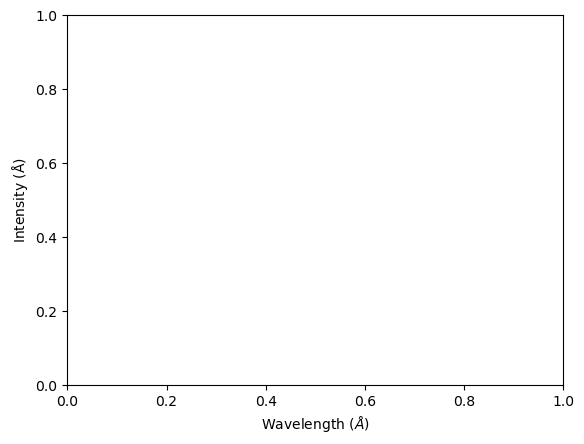

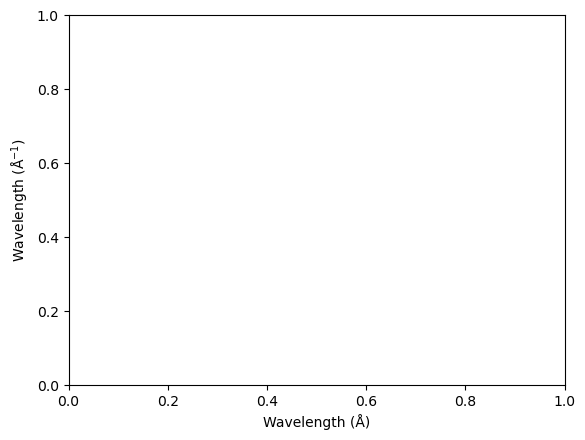

In [ ]:
import matplotlib.pyplot as plt
from main_code import constants as const

plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Intensity ($\mathrm{\AA}$)') # Use \mathrm{\AA} for upright text

plt.show()

# Directly paste the Unicode character
plt.xlabel('Wavelength (Å)')

# Using the Unicode escape sequence
plt.ylabel("Wavelength (\u00C5" + r"$^{-1}$)")

plt.show()


$$M_{BH} = (2.0^{+0.4}_{-0.3}) \cdot 10^6 \cdot \left[\frac{L_{H\alpha}}{10^{42} \text{ erg s}^{-1}}\right]^{0.55 \pm 0.02} \cdot \left[\frac{FWHM_{H\alpha}}{10^3 \text{ km s}^{-1}}\right]^{2.06 \pm 0.06} M_\odot$$

$$\log M = \log a + b \cdot \log L + c \cdot \log V$$

$$\delta(\log M) = \delta(\log a) + \log L \cdot \delta b + b \cdot \delta(\log L) + \log V \cdot \delta c + c \cdot \delta(\log V)$$

$$\sigma^2_{\log M} = \sigma^2_{\log a} + (\log L)^2 \sigma^2_b + b^2 \sigma^2_{\log L} + (\log V)^2 \sigma^2_c + c^2 \sigma^2_{\log V}$$

$$\sigma_{\log_{10} x} = \frac{1}{\ln 10} \cdot \frac{\delta x}{x}$$

$$\delta M = \ln(10) \cdot M \cdot \sigma_{\log_{10} M}$$

 if $y = \log_{10}(x)$, then $\delta x = \ln(10) \cdot x \cdot \delta y$.

In [ ]:
import numpy as np
import scipy.optimize as spo
import scipy.signal as sps
import matplotlib.pyplot as plt

from main_code import helpers
from main_code.constants import *

# --- Step 1: Generate the data ---
# Your original data (a noisy inverted parabola)
np.random.seed(42)
x = np.linspace(-100, 100, 500)
y_true = (
    2000 * np.exp(-(x + 40)**2 / (2 * 15**2)) +  # Peak 1
    3500 * np.exp(-(x - 10)**2 / (2 * 25**2)) +  # Peak 2
    1500 * np.exp(-(x - 60)**2 / (2 * 10**2))    # Peak 3
)
noise = np.random.normal(0, 200, len(x))
y = y_true + noise

# --- Step 2: Define the Gaussian model function ---
# A Gaussian has 3 parameters: amplitude (A), center (mu), and width (sigma)
# The functional form is: f(x) = A * exp(-(x - mu)^2 / (2 * sigma^2))
def my_gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


def n_gaussians(x, n, peaks, mus, sigmas):
    """Sum of n Gaussians"""
    res = np.zeros_like(x)
    for i in range(n):
        res += peaks[i] * np.exp(-(x - mus[i])**2 / (2 * sigmas[i]**2))
    return res

def get_initial_guesses(
    n: int,
    x: np.ndarray,
    y: np.ndarray
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    peak = np.ones(n) * np.max(y)
    mu_guesses = np.ones(n) * x[np.argmax(y)]

    peak_indices = [np.argmax(y)] * n
    fwhm_guesses, _, _, _ = sps.peak_widths(y, peak_indices, rel_height=0.5) # returns width in indices at half max
    peak_x_diffs = helpers.get_masked_diffs(x, peak_indices)
    fwhm_guesses = fwhm_guesses * peak_x_diffs
    sigma_guesses = fwhm_guesses / SIGMA_TO_FWHM

def multi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    """Sum of two Gaussians"""
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    g2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return g1 + g2

# Initial guesses for 2 peaks (you'd adjust these based on your data)
p0_multi = [3000, -30, 30,   # First Gaussian: A1, mu1, sigma1
            3000,  30, 30]   # Second Gaussian: A2, mu2, sigma2

popt_multi, pcov_multi = spo.curve_fit(multi_gaussian, x, y, p0=p0_multi)

perr_multi = np.sqrt(np.diag(pcov_multi))

# --- Step 3: Provide initial guesses for the parameters ---
# Good initial guesses help the optimizer converge faster and avoid local minima
# - A (amplitude): Use the maximum of the data
# - mu (center): Use the x-value where y is maximum
# - sigma (width): Estimate from the data spread (e.g., std dev of x where y > half-max)
A_guess = np.max(y)                    # Peak height
mu_guess = x[np.argmax(y)]             # x-position of peak
sigma_guess = 50                        # Rough estimate of width

p0 = [A_guess, mu_guess, sigma_guess]

# --- Step 4: Perform the curve fit ---
# curve_fit uses non-linear least squares (Levenberg-Marquardt by default)
# It minimizes the sum of squared residuals: Σ(y_data - y_model)^2
popt, pcov = spo.curve_fit(my_gaussian, x, y, p0=p0)

# popt: optimal parameters [A, mu, sigma]
# pcov: covariance matrix (diagonal gives variance of each parameter)

# --- Step 5: Extract results and uncertainties ---
# A_fit, mu_fit, sigma_fit = popt
A_fit_1, mu_fit_1, sigma_fit_1, A_fit_2, mu_fit_2, sigma_fit_2 = popt_multi
# perr = np.sqrt(np.diag(pcov))  # Standard errors from covariance matrix
perr = np.sqrt(np.diag(pcov_multi))  # Standard errors from covariance matrix

print(f"Fitted parameters:")
print(f"  Amplitude A = {A_fit_1:.2f} ± {perr[0]:.2f}")
print(f"  Center μ    = {mu_fit_1:.2f} ± {perr[1]:.2f}")
print(f"  Width σ     = {sigma_fit_1:.2f} ± {perr[2]:.2f}")

# --- Step 6: Plot the result ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=10, alpha=0.5, label='Data')
plt.plot(x, my_gaussian(x, *popt_multi[0:3]), 'r-', linewidth=2, label='Gaussian fit')
plt.plot(x, my_gaussian(x, *popt_multi[3:6]), 'r-', linewidth=2, label='Gaussian fit')
plt.plot(x, my_gaussian(x, *popt_multi[0:3]) + my_gaussian(x, *popt_multi[3:6]), 'r-', linewidth=2, label='Total fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Single Gaussian Fit')
plt.show()